# Imports/tools

Do not forget to attach GPU

In [0]:
import gym
import ptan
import time
import copy
import numpy as np
import universe
import collections
from typing import List, Optional, Tuple
from universe import vectorized
from universe.wrappers.experimental import SoftmaxClickMouse

from PIL import Image, ImageDraw
import matplotlib.pylab as plt

%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
ENV_NAME = "wob.mini.ClickDialog-v0"
PORT_OFFSET = <FILLME>
VM_ADDRESS = "193.49.213.5"

In [0]:
# function to build connection endpoints for set of containers
def remotes_url(port_ofs=PORT_OFFSET, hostname=VM_ADDRESS, count=1):
    hosts = ["%s:%d+%d" % (hostname, 5900 + ofs, 15900 + ofs) for ofs in range(port_ofs, port_ofs+count)]
    return "vnc://" + ",".join(hosts)

In [0]:
def make_env(wrapper_func = lambda env: env, count: int = 1, fps: float = 5) -> universe.envs.VNCEnv:
    """
    Builds the vectorized env
    """
    env = gym.make(ENV_NAME)
    env = wrapper_func(env)
    url = remotes_url(count=count)
    print("Remotes URL: %s" % url)

    env.configure(remotes=url, fps=fps, vnc_kwargs={
            'encoding': 'tight', 'compress_level': 0,
            'fine_quality_level': 100, 'subsample_level': 0
        })
    return env

In [0]:
def join_env(env: universe.envs.VNCEnv):
    """
    Function performs initial reset of the env and waits for observations to become ready
    """
    obs_n = env.reset()
    while any(map(lambda o: o is None, obs_n)):
        a = [env.action_space.sample() for _ in obs_n]
        obs_n, reward, is_done, info = env.step(a)
    return obs_n

In [0]:
class MiniWoBCropper(vectorized.ObservationWrapper):
    """
    Crops the WoB area and converts the observation into PyTorch (C, H, W) format.
    """
    # Area of interest
    WIDTH = 160
    HEIGHT = 210
    X_OFS = 10
    Y_OFS = 75
    
    def __init__(self, env, keep_text=False):
        super(MiniWoBCropper, self).__init__(env)
        self.keep_text = keep_text
        img_space = gym.spaces.Box(low=0, high=255, shape=(3, self.HEIGHT, self.WIDTH))
        if keep_text:
            self.observation_space = gym.spaces.Tuple(spaces=(img_space, gym.spaces.Space))
        else:
            self.observation_space = img_space

    def _observation(self, observation_n):
        res = []
        for obs in observation_n:
            if obs is None:
                res.append(obs)
                continue
            img = obs['vision'][self.Y_OFS:self.Y_OFS+self.HEIGHT, self.X_OFS:self.X_OFS+self.WIDTH, :]
            img = np.transpose(img, (2, 0, 1))
            if self.keep_text:
                text = " ".join(map(lambda d: d.get('instruction', ''), obs.get('text', [{}])))
                res.append((img, text))
            else:
                res.append(img)
        return res

In [0]:
class Model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(Model, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, 5, stride=5),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, n_actions),
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        fx = x.float() / 256
        conv_out = self.conv(fx).view(fx.size()[0], -1)
        return self.fc(conv_out)

In [0]:
@torch.no_grad()
def unpack_batch(batch: List[ptan.experience.ExperienceFirstLast], net: nn.Module, gamma: float, device="cpu"):
    states = []
    actions = []
    rewards = []
    done_masks = []
    last_states = []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        done_masks.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)

    states_v = torch.tensor(states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    last_states_v = torch.tensor(last_states).to(device)
    last_state_q_v = net(last_states_v)
    best_last_q_v = torch.max(last_state_q_v, dim=1)[0]
    best_last_q_v[done_masks] = 0.0
    return states_v, actions_v, best_last_q_v + rewards_v

# Troubleshooting of Baseline DQN

> "You love Linux, probably you're experienced in troubleshooting..."
> RHCE Exam Instructor @ 2005

Code above doesn't converge. Usually, in such situations, tutorial author tweaks the parameters to make it working, so, attendants see only final, polished version. This makes the false impression of ML as smooth and quite obvious process, which very far from truth. Don't know about others, but my code doesn't work 90% of the time :).

To learn how to deal with such situations, you're asked to troubleshoot the code above. There are several directions you could explore (of course, you can have your own ideas, that's not the complete list):

* check training samples. Do they make sense? Is reward properly assigned to correct observations?
* training gradients. How large they are? What's the ratio of gradients/weight values?
* do end-of-episode steps handled properly? Final steps of epsiodes act as an anchor to prevent Q values from growing infinitely, so, it is critical to have them properly handled in Bellman equation
* explore Q values produced by the network during the training. Are they growing over time? That's a good practice to have small set of states (including final step and steps before the final) and track their Qs during the training.
* how large the difference between trained network and target net used for next-step Bellman approximation? How it changes over time?


In [0]:
GAMMA = 0.9
REPLAY_SIZE = 10000
MIN_REPLAY = 100
TGT_SYNC = 100
BATCH_SIZE = 16
LR = 1e-4
DEVICE = "cuda"  
#DEVICE = "cpu"

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.2
STEPS_EPSILON = 1000
LIMIT_STEPS = 1500

## Training samples check

Here we're going to eyeball our training samples. OpenAI Universe is asynchronous, so, if we're missing a frame or have delays to handle input data, we can get weird training samples.

To do this, we implement small `Env` wrapper applied after `MiniWoBCropper` to keep history of training sequences.

In [0]:
class TrajectoryTracking(vectorized.Wrapper):
    """
    Keeps last N trajectories from the environment
    """
    def __init__(self, env, size: int):
        super(TrajectoryTracking, self).__init__(env)
        self.trajectories = collections.deque(maxlen=size)
        self._in_progress = []

    def reset(self):
        obs_n = self.env.reset()
        if not self._in_progress:
            self._in_progress = [[] for _ in obs_n]
        for t, obs in zip(self._in_progress, obs_n):
            if t:
                self.trajectories.append(list(t))
                t.clear()
            if obs:
                t.append(obs)
        return obs_n
    
    def step(self, action_n):
        obs_n, r_n, done_n, info_n = self.env.step(action_n)
        for t, obs, r, act in zip(self._in_progress, obs_n, r_n, action_n):
            t.append((obs, act, r))
        for t, done in zip(self._in_progress, done_n):
            if done:
                self.trajectories.append(list(t))
                t.clear()
        return obs_n, r_n, done_n, info_n

Let's apply it to our training to get trajectories to check

In [12]:
def wrapper_func(env):
    env = MiniWoBCropper(env)
    env = SoftmaxClickMouse(env)
    env = TrajectoryTracking(env, size=10)
    return env

# Note FPS decrease to get smaller amount of images
env = make_env(wrapper_func = wrapper_func, fps=1)
join_env(env);

[2019-07-10 11:35:31,547] Making new env: wob.mini.ClickDialog-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-10 11:35:31,558] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-10 11:35:31,560] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-10 11:35:31,562] Writing logs to file: /tmp/universe-10207.log
[2019-07-10 11:35:31,569] Using the golang VNC implementation
[2019-07-10 11:35:31,571] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-10 11:35:31,578] [0] Connecting to environment: vnc://193.49.213.5:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most e

Remotes URL: vnc://193.49.213.5:5900+15900


[2019-07-10 11:35:51,806] [0:193.49.213.5:5900] ntpdate -q -p 8 193.49.213.5 call timed out after 20.0s; killing the subprocess. This is ok, but you could have more accurate timings by enabling UDP port 123 traffic to your env. (Alternatively, you can try increasing the timeout by setting environment variable UNIVERSE_NTPDATE_TIMEOUT=10.)
[2019-07-10 11:35:53,961] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-10 11:35:54,160] [0:193.49.213.5:5900] Initial reset complete: episode_id=15217


In [0]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)

In [14]:
# populate buffer to get some trajectories
for _ in range(100):
    buffer.populate(1)
    for rw, st in exp_source.pop_rewards_steps():
        print("Episode done with %d steps and %.3f reward" % (st, rw))

[2019-07-10 11:36:08,824] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


Episode done with 2 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 4 steps and 0.638 reward
Episode done with 10 steps and -1.000 reward


In [15]:
len(env.trajectories)

10

In [16]:
list(map(len, env.trajectories))

[10, 11, 10, 11, 10, 11, 11, 4, 10, 11]

In [18]:
# you might want to select different trajectory to check, I've chosen not very long one with positive reward
tr = env.trajectories[-3]
tr_obs, tr_act, tr_rw = zip(*tr)
tr_act, tr_rw

((115, 46, 180, 165), (0.0, 0.0, 0.0, 0.6376000000000001))

In [0]:
def get_obs_img(obs, action=None, action_step_pix=10, action_y_ofs=50, transpose=True):
    """
    Get the image from observation with optional action place shown
    """
    if transpose:
        obs = np.transpose(obs, (1, 2, 0))
    img = Image.fromarray(obs)
    if action is not None:
        draw = ImageDraw.Draw(img)
        if isinstance(action, tuple):
            x_ofs, y_ofs = action
        else:
            y_ofs = action_y_ofs + (action % 16) * action_step_pix
            x_ofs = (action // 16) * action_step_pix
        half_step = action_step_pix//2
        draw.ellipse((x_ofs-half_step, y_ofs-half_step, x_ofs+half_step, y_ofs+half_step),
                     (0, 0, 255, 128))
    return img

In [0]:
imgs = [get_obs_img(obs, action=act) for obs, act in zip(tr_obs, tr_act)]

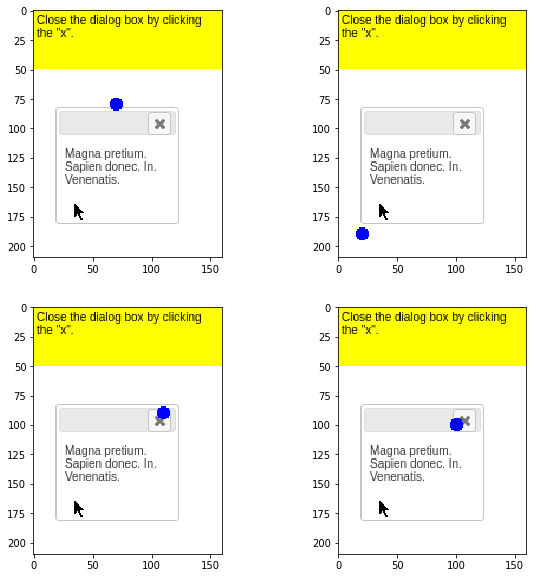

In [21]:
fig = plt.figure(figsize=(10, 10))

rows = 2
for i, img in enumerate(imgs, start=1):
    fig.add_subplot(rows, np.ceil(len(imgs)/rows), i)
    plt.imshow(img)
plt.show()

Ok, looks like reward is assigned to the last step, but not to the step with correct action. Let's check what happens with higher FPS value

In [22]:
def wrapper_func(env):
    env = MiniWoBCropper(env)
    env = SoftmaxClickMouse(env)
    env = TrajectoryTracking(env, size=10)
    return env

env = make_env(wrapper_func = wrapper_func, fps=5)
join_env(env);

[2019-07-10 11:39:02,915] Making new env: wob.mini.ClickDialog-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-10 11:39:02,921] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-10 11:39:02,924] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-10 11:39:02,929] Using the golang VNC implementation
[2019-07-10 11:39:02,931] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-10 11:39:02,942] [0] Connecting to environment: vnc://193.49.213.5:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://193.49.21

Remotes URL: vnc://193.49.213.5:5900+15900


[2019-07-10 11:39:23,202] [0:193.49.213.5:5900] ntpdate -q -p 8 193.49.213.5 call timed out after 20.0s; killing the subprocess. This is ok, but you could have more accurate timings by enabling UDP port 123 traffic to your env. (Alternatively, you can try increasing the timeout by setting environment variable UNIVERSE_NTPDATE_TIMEOUT=10.)
[2019-07-10 11:39:25,354] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-10 11:39:25,497] [0:193.49.213.5:5900] Initial reset complete: episode_id=15240


In [0]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)

In [24]:
# populate buffer to get some trajectories
for _ in range(500):
    buffer.populate(1)
    for rw, st in exp_source.pop_rewards_steps():
        print("Episode done with %d steps and %.3f reward" % (st, rw))

[2019-07-10 11:43:08,582] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


Episode done with 32 steps and -1.000 reward
Episode done with 28 steps and 0.504 reward
Episode done with 17 steps and 0.711 reward
Episode done with 52 steps and -1.000 reward
Episode done with 53 steps and -1.000 reward
Episode done with 21 steps and 1.661 reward
Episode done with 53 steps and -1.000 reward
Episode done with 15 steps and 0.761 reward
Episode done with 52 steps and -1.000 reward
Episode done with 47 steps and 0.099 reward
Episode done with 53 steps and -1.000 reward
Episode done with 52 steps and -1.000 reward
Episode done with 24 steps and 0.591 reward


One thing to notice here: we have much higher success rate due to more clicks done.

In [25]:
list(map(len, env.trajectories))

[52, 53, 21, 53, 15, 52, 47, 53, 52, 24]

In [27]:
# you might want to select different trajectory to check, I've chosen not very long one with positive reward
tr = env.trajectories[-1]
tr_obs, tr_act, tr_rw = zip(*tr)
print(tr_act)
print(tr_rw)

(193, 7, 18, 172, 254, 203, 156, 189, 166, 3, 112, 229, 0, 132, 184, 40, 102, 68, 193, 157, 85, 181, 232, 19)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5908)


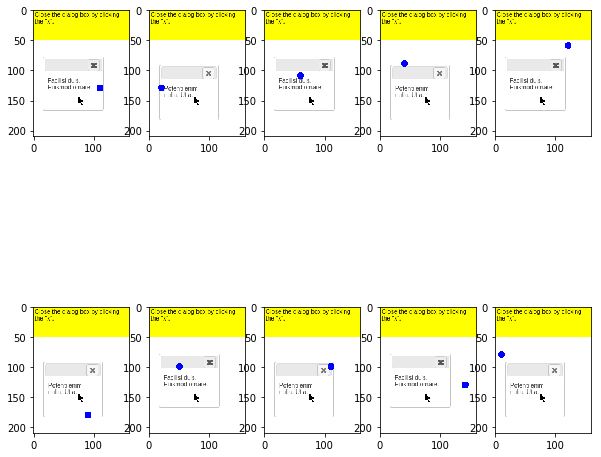

In [28]:
imgs = [get_obs_img(obs, action=act) for obs, act in zip(tr_obs, tr_act)]

fig = plt.figure(figsize=(10, 10))

rows = 2
for i, img in enumerate(imgs[-10:], start=1):
    fig.add_subplot(rows, np.ceil(len(imgs[-10:])/rows), i)
    plt.imshow(img)
plt.show()

Hm, looks like the last step in the trajectory is confusing. Let's check the contents of the replay buffer

In [29]:
len(buffer)

500

In [30]:
# buffer is just a container of objects of ExperienceFirstLast 
# (https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L155)
# which just a namedtuple with fields: state, action, reward, last_state
final_good = []
final_bad = []
for s in buffer:
    if s.last_state is None:
        if s.reward > 0.2:
            final_good.append(s)
        elif s.reward < -0.2:
            final_bad.append(s)
print("Found %d final good states and %d final bad" % (len(final_good), len(final_bad)))

Found 5 final good states and 7 final bad


In [0]:
final_good_imgs = [get_obs_img(s.state, action=s.action) for s in final_good]
final_bad_imgs = [get_obs_img(s.state, action=s.action) for s in final_bad]

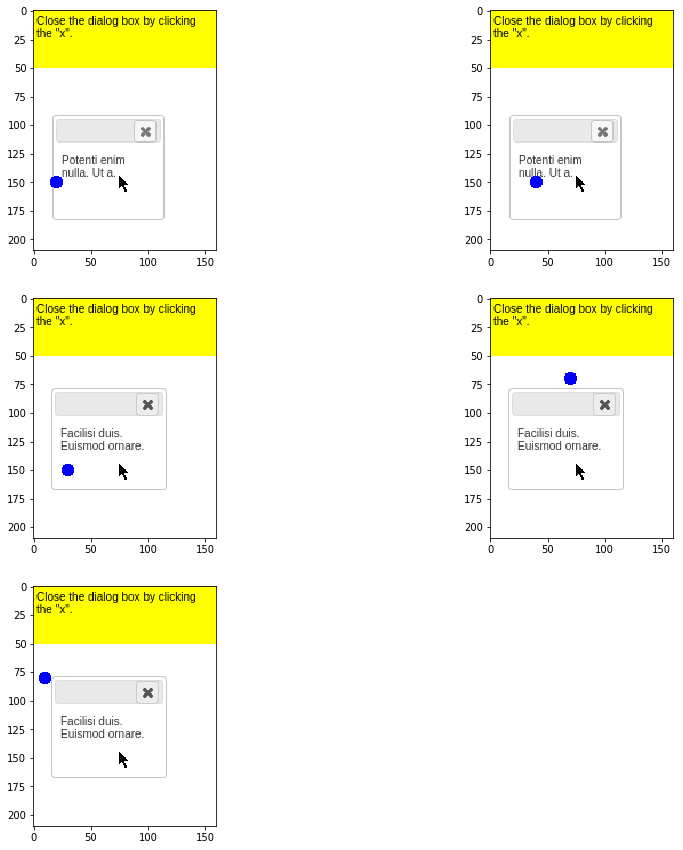

In [32]:
fig = plt.figure(figsize=(15, 15))

rows = 3
for i, img in enumerate(final_good_imgs, start=1):
    fig.add_subplot(rows, np.ceil(len(final_good_imgs)/rows), i)
    plt.imshow(img)
plt.show()

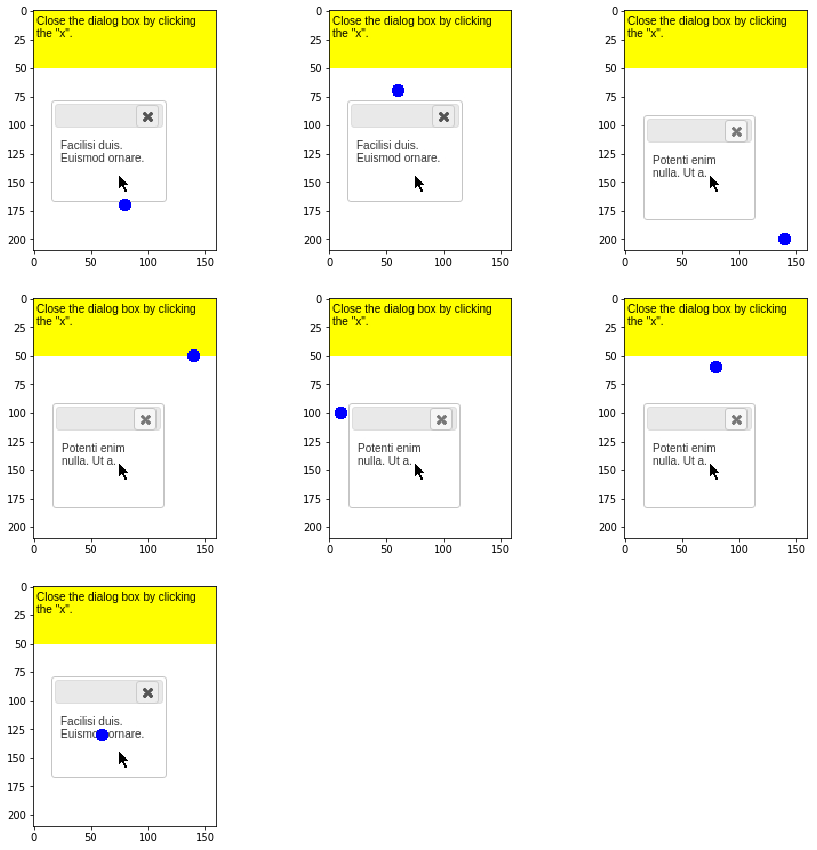

In [33]:
fig = plt.figure(figsize=(15, 15))

rows = 3
for i, img in enumerate(final_bad_imgs, start=1):
    fig.add_subplot(rows, np.ceil(len(final_bad_imgs)/rows), i)
    plt.imshow(img)
plt.show()

Ok, obviously, async nature of Gym is confusing the training. Let's leave it for now and check other aspects of our training process.

## Overfit to subset of samples

Normal approach to debug ML/DL methods is to try to overfit to some known set of samples. This allows us to inspect those samples and check values predicted by the model. It might sound trivial, but I've personally wasted several days debugging proper code, the only issue with which was lack of `loss.backward()`. 

Overall plan is the following:
* reuse our class `TrajectoryTracking` to have access to trajectories,
* play 10-20 episodes gathering data
* take several final steps of successfull episodes (with positive reward) and several final steps from failed episodes
* train on this data for several epoches
* check training dynamics and values returned by the model
* think

If you feel yourself brave enough, you can try to implement this yourself without peeking into the next section.

In [34]:
def wrapper_func(env):
    env = MiniWoBCropper(env)
    env = SoftmaxClickMouse(env)
    env = TrajectoryTracking(env, size=10)
    return env

env = make_env(wrapper_func = wrapper_func, fps=5)
join_env(env);

[2019-07-10 11:46:51,479] Making new env: wob.mini.ClickDialog-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-10 11:46:51,488] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-10 11:46:51,491] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-10 11:46:51,495] Using the golang VNC implementation
[2019-07-10 11:46:51,496] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-10 11:46:51,503] [0] Connecting to environment: vnc://193.49.213.5:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://193.49.21

Remotes URL: vnc://193.49.213.5:5900+15900


[2019-07-10 11:47:11,758] [0:193.49.213.5:5900] ntpdate -q -p 8 193.49.213.5 call timed out after 20.0s; killing the subprocess. This is ok, but you could have more accurate timings by enabling UDP port 123 traffic to your env. (Alternatively, you can try increasing the timeout by setting environment variable UNIVERSE_NTPDATE_TIMEOUT=10.)
[2019-07-10 11:47:13,913] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-10 11:47:14,141] [0:193.49.213.5:5900] Initial reset complete: episode_id=15289


In [0]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)

In [36]:
# wait for given amount of trajectories of both kind
COUNT_REQUIRED = 2
positive_traj = []
negative_traj = []

while len(positive_traj) < COUNT_REQUIRED or len(negative_traj) < COUNT_REQUIRED:
    buffer.populate(1)
    for rw, st in exp_source.pop_rewards_steps():
        print("Episode done with %d steps and %.3f reward" % (st, rw))
        if rw > 0.2  and len(positive_traj) <= COUNT_REQUIRED:
            positive_traj.append(env.trajectories[-1])
        elif rw < -0.2 and len(negative_traj) <= COUNT_REQUIRED:
            negative_traj.append(env.trajectories[-1])

[2019-07-10 11:47:20,580] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


Episode done with 29 steps and -1.000 reward
Episode done with 51 steps and 0.044 reward
Episode done with 52 steps and -1.000 reward
Episode done with 53 steps and -1.000 reward
Episode done with 30 steps and 0.450 reward
Episode done with 52 steps and -1.000 reward
Episode done with 53 steps and -1.000 reward
Episode done with 45 steps and 0.149 reward
Episode done with 13 steps and 0.791 reward


It might take some time before you get two episodes with positive reward.

Btw, sparcity of good examples might be the reason of bad convergence. Possible way dealing with that could be increase of `fps` option on Env creation, just to have more clicks done.

In [37]:
for s in positive_traj[0]:
    print(s[1], s[2])

212 0.0
195 0.0
59 0.0
104 0.0
24 0.0
172 0.0
109 0.0
17 0.0
237 0.0
227 0.0
163 0.0
105 0.0
221 0.0
162 0.0
228 0.0
10 0.0
47 0.0
77 0.0
195 0.0
152 0.0
158 0.0
230 0.0
224 0.0
6 0.0
173 0.0
118 0.0
37 0.0
131 0.0
245 0.0
104 0.44980000000000003


In [38]:
training_positive = []

# find this sample in our replay buffer
for traj in positive_traj:
    for sample in buffer:
        # note that we're taking the observation from the previous step in trajectory, but action from the last
        if (sample.state == traj[-2][0]).all() and sample.action == traj[-1][1] and sample.last_state is None:
            training_positive.append(sample)
len(training_positive)

2

In [39]:
training_negative = []

for traj in negative_traj:
    for sample in buffer:
        if (sample.state == traj[-2][0]).all() and sample.action == traj[-1][1] and sample.last_state is None:
            training_negative.append(sample)
len(training_negative)            

3

In [0]:
batch = list(training_positive)
batch.extend(training_negative)

In [0]:
optimizer = optim.Adam(net.parameters(), LR)

In [0]:
# training the net
losses = []
q_vals = []

for _ in range(100):
    state_v, actions_v, ref_q_v = unpack_batch(batch, net, gamma=GAMMA, device=DEVICE)
    optimizer.zero_grad()
    q_v = net(state_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, ref_q_v)
    loss_v.backward()
    optimizer.step()
    losses.append(loss_v.item())
    q_vals.append(q_v.cpu().detach().numpy())

In [43]:
losses[:10]

[0.8212960362434387,
 0.5348292589187622,
 0.30748891830444336,
 0.1400965452194214,
 0.043585628271102905,
 0.024871738627552986,
 0.06505951285362244,
 0.1075073704123497,
 0.11591682583093643,
 0.09477385133504868]

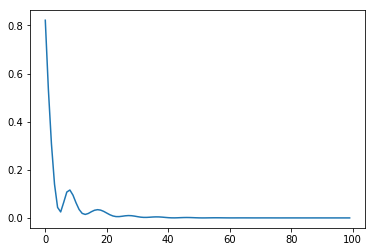

In [44]:
plt.plot(losses);

In [45]:
ref_q_v

tensor([ 0.4498,  0.7912, -1.0000, -1.0000, -1.0000], device='cuda:0')

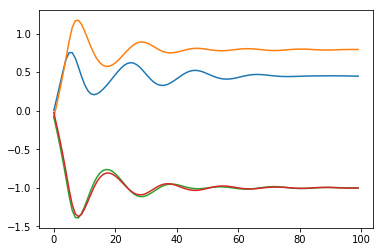

In [47]:
a, b, c, d, *_ = zip(*q_vals)
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot(d);

In [48]:
ref_q_v

tensor([ 0.4498,  0.7912, -1.0000, -1.0000, -1.0000], device='cuda:0')

Looks OK

# Fixing the weird samples

Let's return to our finding of weird samples at the end of trajectories. It is obvious (from Bellman equation) that those samples are extremely important for convergence, as they form the "basis" of our Q-values. So, network need to converge to those end-of-episode values and then they will be used to learn more early steps (or find shorter paths to those final states).

But our end-of-episodes samples are nasty -- we can click at proper place, but due to timeout get -1 reward on the next step. On the other hand, we can click properly in the beginning, but due to VNC delay, we'll get positive reward several steps later. And those steps will include completely random clicks. This situation also turns our environment into POMDP domain. Indeed, prior clicks are important for subsequent trajectory, but our agent has no idea about the clicks we've done. 

We can't fix asynchronous nature of things, but we can help our agent by cleaning up the mess a bit.

As a very simple approach, we can wait for a some time after every action.

To fix the POMDP, we just need to remember previous clicks and pass them to the agent in observation. The simplest way of doing this will be to have a separate "color plane" in observations with filled grids we've already clicked.

Below is outline of two wrappers we need to write.

## Track clicks wrapper

In [0]:
class MiniWoBTrackClicks(vectorized.Wrapper):
    """
    Track the clicks
    """
    def __init__(self, env):
        super(MiniWoBTrackClicks, self).__init__(env)
        s = env.observation_space.shape
        self.clicks_buf = np.zeros(s[1:], dtype=np.uint8)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(s[0]+1, s[1], s[2]))

    def reset(self):
        self.clicks_buf[:] = 0
        return self.env.reset()
    
    def step(self, action_n):
        obs_n, r_n, done_n, info_n = self.env.step(action_n)
        if obs_n[0] is None:
            return obs_n, r_n, done_n, info_n

        # track the click
        # append the color plane to observation
        # if episode is done, reset the click buffer
        raise NotImplementedError
        return obs_n, r_n, done_n, info_n

## Tests

In [51]:
def wrapper_func(env):
    env = MiniWoBCropper(env)
    env = SoftmaxClickMouse(env)
    env = MiniWoBTrackClicks(env)
    return env

env = make_env(wrapper_func = wrapper_func, fps=5)
obs_n = join_env(env);

[2019-07-10 11:53:47,826] Making new env: wob.mini.ClickDialog-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-10 11:53:47,837] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-10 11:53:47,842] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-10 11:53:47,850] Using the golang VNC implementation
[2019-07-10 11:53:47,853] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-10 11:53:47,858] [0] Connecting to environment: vnc://193.49.213.5:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://193.49.21

Remotes URL: vnc://193.49.213.5:5900+15900


[2019-07-10 11:54:08,115] [0:193.49.213.5:5900] ntpdate -q -p 8 193.49.213.5 call timed out after 20.0s; killing the subprocess. This is ok, but you could have more accurate timings by enabling UDP port 123 traffic to your env. (Alternatively, you can try increasing the timeout by setting environment variable UNIVERSE_NTPDATE_TIMEOUT=10.)
[2019-07-10 11:54:10,270] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-10 11:54:10,390] [0:193.49.213.5:5900] Initial reset complete: episode_id=15332


In [0]:
assert obs_n[0].shape == (4, 210, 160)

In [53]:
# wait for fresh observation
while True:
    _, _, is_done_n, _ = env.step([0])
    if is_done_n[0]:
        break
o0, _, _, _ = env.step([0])
o255, _, _, _ = env.step([255])
o15, _, _, _ = env.step([15])

[2019-07-10 11:54:24,884] Throttle fell behind by 14.17s; lost 70.85 frames


In [0]:
assert (o0[0][3,:,:] == 255).sum() == 100
assert (o255[0][3,:,:] == 255).sum() == 200
assert (o15[0][3,:,:] == 255).sum() == 300

In [0]:
nz0 = o0[0][3,:,:].nonzero()
assert (nz0[0] == [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53,
        53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55,
        55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56,
        56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58,
        58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59]).all()
assert (nz0[1] == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).all()

In [0]:
assert (o15[0][3,200:210,0:10] == 255).all()

## Solution

In [0]:
class MiniWoBTrackClicks(vectorized.Wrapper):
    """
    Track the clicks
    """
    def __init__(self, env):
        super(MiniWoBTrackClicks, self).__init__(env)
        s = env.observation_space.shape
        self.clicks_buf = np.zeros(s[1:], dtype=np.uint8)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(s[0]+1, s[1], s[2]))

    def reset(self):
        self.clicks_buf[:] = 0
        return self.env.reset()
    
    def step(self, action_n):
        # TODO: implement me properly for N environments :)
        obs_n, r_n, done_n, info_n = self.env.step(action_n)
        if obs_n[0] is None:
            return obs_n, r_n, done_n, info_n

        # track the click
        x = action_n[0] // 16
        y = action_n[0] % 16 + 5    # +5 is needed to offset click region down 50 pixels
        self.clicks_buf[y*10:(y+1)*10, x*10:(x+1)*10] = 255
        
        obs_n[0] = np.vstack((obs_n[0], [self.clicks_buf]))
        if done_n[0]:
            self.clicks_buf[:] = 0
        return obs_n, r_n, done_n, info_n

## Click and wait obs transformation

In [0]:
class MiniWoBSlowpoke(vectorized.Wrapper):
    """
    Sleeps after every click
    """
    def __init__(self, env, click_delay: float = 0.5):
        super(MiniWoBSlowpoke, self).__init__(env)
        self.click_delay = click_delay
        self.click_ts = None

    def reset(self):
        self.click_ts = None
        return self.env.reset()
    
    def step(self, action_n):
        # wait if the time budget is positive using time.sleep() function
        # do the step
        # track the click time (do not forget about the case when done_n[0] == True)
        raise NotImplementedError

## Tests

In [58]:
def wrapper_func(env):
    env = MiniWoBCropper(env)
    env = SoftmaxClickMouse(env)
    env = MiniWoBSlowpoke(env, click_delay=1)
    return env

env = make_env(wrapper_func = wrapper_func, fps=5)
join_env(env);

[2019-07-10 11:54:55,431] Making new env: wob.mini.ClickDialog-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-10 11:54:55,442] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-10 11:54:55,451] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-10 11:54:55,455] Using the golang VNC implementation
[2019-07-10 11:54:55,460] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-10 11:54:55,466] [0] Connecting to environment: vnc://193.49.213.5:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://193.49.21

Remotes URL: vnc://193.49.213.5:5900+15900


[2019-07-10 11:55:15,728] [0:193.49.213.5:5900] ntpdate -q -p 8 193.49.213.5 call timed out after 20.0s; killing the subprocess. This is ok, but you could have more accurate timings by enabling UDP port 123 traffic to your env. (Alternatively, you can try increasing the timeout by setting environment variable UNIVERSE_NTPDATE_TIMEOUT=10.)
[2019-07-10 11:55:17,882] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-10 11:55:23,102] [0:193.49.213.5:5900] Initial reset complete: episode_id=15340


In [59]:
# FPS=5 should give us 10 frames in wrapped environment and 50 in unwrapped for each episode
frames = 0
episodes = 6
while episodes > 0:
    # clicking in top-left corner, we should get no reward from this action
    # it should be fine to sleep a bit
    time.sleep(0.4)
    _, _, is_done_n, _ = env.step([0])
    # do not take into account first episode, it will be partial
    if episodes < 6:
        frames += 1
    if is_done_n[0]:
        episodes -= 1
        print("Episode done, %d left" % episodes)

Episode done, 5 left
Episode done, 4 left
Episode done, 3 left
Episode done, 2 left
Episode done, 1 left
Episode done, 0 left


In [0]:
assert 8 < frames/5 < 13

## Solution

Spoiler alert!

In [0]:
class MiniWoBSlowpoke(vectorized.Wrapper):
    """
    Limits the amount of time we can click.
    """
    def __init__(self, env, click_delay: float = 1):
        super(MiniWoBSlowpoke, self).__init__(env)
        self.click_delay = click_delay
        self.click_ts = None

    def reset(self):
        self.click_ts = None
        return self.env.reset()
    
    def step(self, action_n):
        # TODO: implement me properly for N environments :)
        if self.click_ts is not None:
            dt = self.click_delay - (time.time() - self.click_ts)
            if dt > 0:
                time.sleep(dt)
        obs_n, r_n, done_n, info_n = self.env.step(action_n)
        if done_n[0]:
            self.click_ts = None
        else:
            self.click_ts = time.time()
        return obs_n, r_n, done_n, info_n

# Checking the effect

In [0]:
GAMMA = 0.9
REPLAY_SIZE = 10000
MIN_REPLAY = 100
TGT_SYNC = 100
BATCH_SIZE = 16
LR = 1e-4
DEVICE = "cuda"  
#DEVICE = "cpu"

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.2
STEPS_EPSILON = 1000
LIMIT_STEPS = 1500

In [62]:
def wrapper_func(env):
    env = MiniWoBCropper(env)
    env = SoftmaxClickMouse(env)
    env = MiniWoBTrackClicks(env)
    env = MiniWoBSlowpoke(env, click_delay=0.5)
    return env

env = make_env(wrapper_func = wrapper_func, fps=5)
obs_n = join_env(env);

[2019-07-10 11:57:01,199] Making new env: wob.mini.ClickDialog-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-10 11:57:01,210] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-10 11:57:01,216] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-10 11:57:01,221] Using the golang VNC implementation
[2019-07-10 11:57:01,222] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-10 11:57:01,237] [0] Connecting to environment: vnc://193.49.213.5:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://193.49.21

Remotes URL: vnc://193.49.213.5:5900+15900


[2019-07-10 11:57:21,493] [0:193.49.213.5:5900] ntpdate -q -p 8 193.49.213.5 call timed out after 20.0s; killing the subprocess. This is ok, but you could have more accurate timings by enabling UDP port 123 traffic to your env. (Alternatively, you can try increasing the timeout by setting environment variable UNIVERSE_NTPDATE_TIMEOUT=10.)
[2019-07-10 11:57:23,651] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-10 11:57:23,896] [0:193.49.213.5:5900] Initial reset complete: episode_id=15353


In [0]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
tgt_net = ptan.agent.TargetNet(net)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=INITIAL_EPSILON, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)
optimizer = optim.Adam(net.parameters(), LR)

In [0]:
best_weights = None
best_mean10_reward = None
episode_rewards = []
episode_steps = []
losses = []
steps = 0
last_ts = time.time()
last_steps = 0

while steps < LIMIT_STEPS:
    steps += 1
    buffer.populate(1)
    r = exp_source.pop_rewards_steps()
    if r:
        for rw, st in r:
            episode_rewards.append(rw)
            episode_steps.append(st)
        speed = (steps - last_steps) / (time.time() - last_ts)
        print("%d: Done %d episodes, last 10 means: reward=%.3f, steps=%.3f, speed=%.2f steps/s, eps=%.2f" % (
            steps, len(episode_rewards), np.mean(episode_rewards[-10:]), 
            np.mean(episode_steps[-10:]), speed, action_selector.epsilon
        ))
        last_ts = time.time()
        last_steps = steps
        if np.mean(episode_rewards[-10:]) > 0.9:
            print("You solved the env! Congrats!")
            break
    if len(buffer) < MIN_REPLAY:
        continue
    batch = buffer.sample(BATCH_SIZE)
    state_v, actions_v, ref_q_v = unpack_batch(batch, tgt_net.target_model, gamma=GAMMA, device=DEVICE)
    optimizer.zero_grad()
    q_v = net(state_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, ref_q_v)
    loss_v.backward()
    optimizer.step()
    losses.append(loss_v.item())
    
    if steps % TGT_SYNC == 0:
        print("%d: nets synced, mean loss for last 10 steps = %.3f" % (
            steps, np.mean(losses[-10:])))
        tgt_net.sync()
    action_selector.epsilon = max(FINAL_EPSILON, INITIAL_EPSILON - (steps-MIN_REPLAY) / STEPS_EPSILON)
    
    if action_selector.epsilon < 0.4:
        m10_reward = np.mean(episode_rewards[-10:])
        if best_mean10_reward is None or m10_reward > best_mean10_reward:
            print("%d: best reward updated: %s -> %.3f, weights saved" % (
                steps, best_mean10_reward, m10_reward
            ))
            best_mean10_reward = m10_reward
            # deep copy is required as state_dict() is just reference to tensors which are being kept on GPU
            best_weights = copy.deepcopy(net.state_dict())

[2019-07-10 11:57:24,118] [0:193.49.213.5:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


18: Done 1 episodes, last 10 means: reward=-1.000, steps=18.000, speed=1.81 steps/s, eps=1.00
29: Done 2 episodes, last 10 means: reward=-0.260, steps=15.000, speed=1.92 steps/s, eps=1.00
50: Done 3 episodes, last 10 means: reward=-0.506, steps=17.333, speed=1.95 steps/s, eps=1.00
65: Done 4 episodes, last 10 means: reward=-0.314, steps=17.000, speed=1.94 steps/s, eps=1.00
75: Done 5 episodes, last 10 means: reward=-0.145, steps=15.800, speed=1.91 steps/s, eps=1.00
96: Done 6 episodes, last 10 means: reward=-0.288, steps=16.833, speed=1.95 steps/s, eps=1.00
100: nets synced, mean loss for last 10 steps = 0.054
109: Done 7 episodes, last 10 means: reward=-0.247, steps=16.429, speed=1.82 steps/s, eps=0.99
129: Done 8 episodes, last 10 means: reward=-0.296, steps=17.000, speed=1.88 steps/s, eps=0.97
148: Done 9 episodes, last 10 means: reward=-0.374, steps=17.333, speed=1.88 steps/s, eps=0.95
168: Done 10 episodes, last 10 means: reward=-0.437, steps=17.700, speed=1.88 steps/s, eps=0.93
1

In [0]:
# testing the best weights
net.load_state_dict(best_weights)
TEST_EPISODES = 10

rewards = []
steps = []
while len(rewards) < TEST_EPISODES:
    cur_reward = 0
    cur_steps = 0
    obs_n = join_env(env)
    while True:
        obs_t = torch.tensor(obs_n).to(DEVICE)
        q_t = net(obs_t)
        action = q_t.max(dim=1).indices[0].item()
        obs_n, reward_n, is_done_n, _ = env.step([action])
        cur_reward += reward_n[0]
        cur_steps += 1
        if is_done_n[0]:
            break
    rewards.append(cur_reward)
    steps.append(cur_steps)
    print("Episode done in %d steps with %.3f reward" % (cur_steps, cur_reward))
print("Mean reward for %d episodes is %.3f, steps %.3f" % (TEST_EPISODES, np.mean(rewards), np.mean(steps)))

Oh, the problem is open-ended! Will give a beer to the first who makes the damn thing working :). Otherwise, the beer will go to TAs, they worth it.

The interesting thing is that A2C method converges much better without any tweaking ([code is here](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/tree/master/Chapter13)), but requires 6-8 containers running in parallel due to on-policy.
